In [1]:
!pip install shap scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import shap
from sklearn import set_config
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from skopt import BayesSearchCV

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader,  Dataset
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets


plt.rcParams['figure.figsize'] = [20, 10]

We're always learning new things, this is something I learned, sklearn can output pandas! which makes our life easier!

In [ ]:
set_config(transform_output="pandas")

Get the survival data from the titantic, classic dataset to model survival

In [ ]:
X, y = fetch_openml(
    "titanic", version=1, as_frame=True, return_X_y=True, parser="pandas"
)

Mush stuff together for plotting

In [ ]:
X['y'] = y.map(int)

<Axes: xlabel='age', ylabel='Count'>

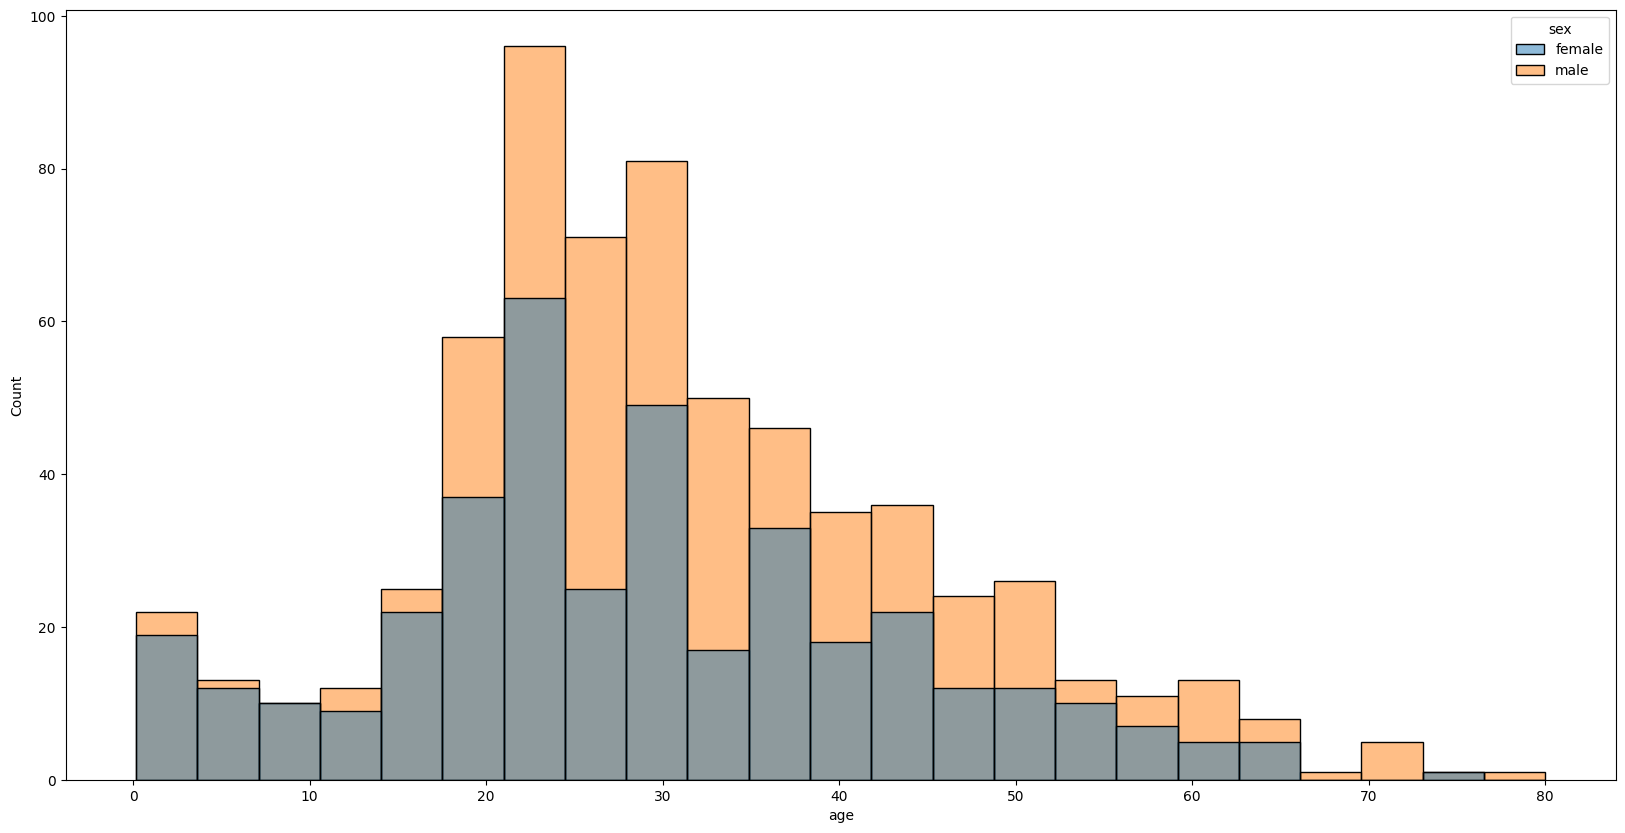

In [ ]:
sns.histplot(X, x = 'age', hue = 'sex')

<Axes: xlabel='age', ylabel='fare'>

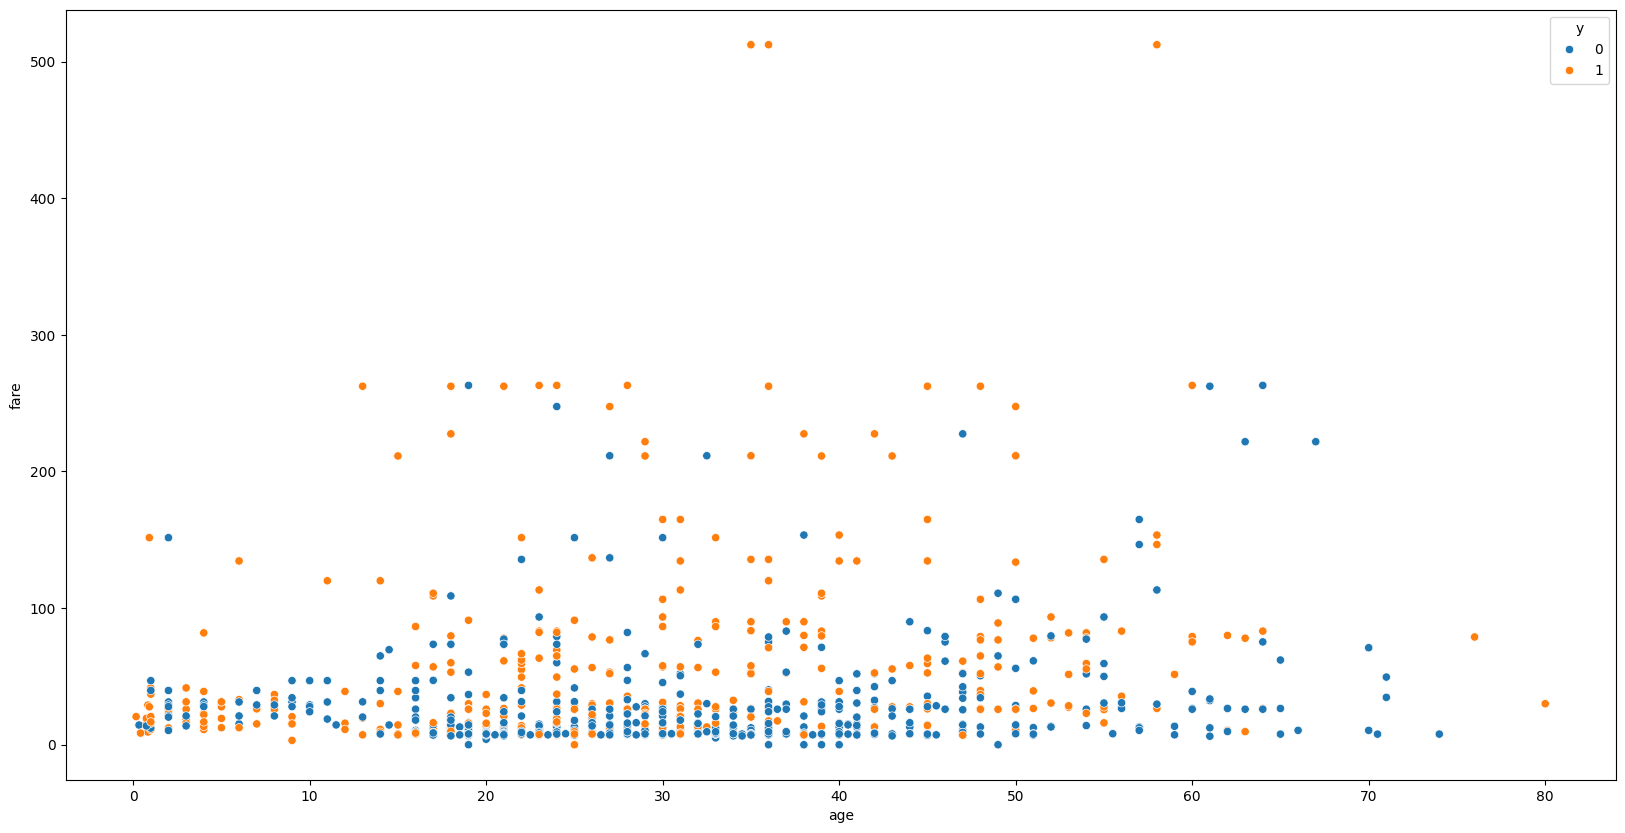

In [ ]:
sns.scatterplot(X, x = 'age', y = 'fare', hue = 'y')

In [ ]:
X.head(5)

pclass                                             name     sex      age  \
0       1                    Allen, Miss. Elisabeth Walton  female  29.0000   
1       1                   Allison, Master. Hudson Trevor    male   0.9167   
2       1                     Allison, Miss. Helen Loraine  female   2.0000   
3       1             Allison, Mr. Hudson Joshua Creighton    male  30.0000   
4       1  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female  25.0000   

   sibsp  parch  ticket      fare    cabin embarked boat   body  \
0      0      0   24160  211.3375       B5        S    2    NaN   
1      1      2  113781  151.5500  C22 C26        S   11    NaN   
2      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  y  
0                     St Louis, MO  1  
1  Montreal, PQ / Chesterville, ON  1  
2  Montreal, PQ / Chesterville, ON  0  
3  Montreal, PQ / Chesterville, ON  0  
4  Montreal, PQ / Chesterville, ON  0

We're going to create a data pipeline. So we can transform all of our variables in one go

The scaler will standardize the units and impute missing data with the median. A onehotencoder will unpack categorical data into it's own indiactor column.

In [ ]:
numeric_features = ['age', 'sibsp', 'fare']
categorical_features = ['embarked', 'sex', 'pclass']

In [ ]:
train_X_raw, test_X_raw, train_y, test_y = train_test_split(X[numeric_features+categorical_features], X['y'])

In [ ]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output = False, drop = 'if_binary'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


#preprocessor.set_output('pandas')

In [ ]:
preproc = preprocessor.fit(train_X_raw)

As always we split the data

In [ ]:
train_X = preproc.transform(train_X_raw)
test_X = preproc.transform(test_X_raw)

Let's start with a GLM

In [ ]:
clf = LogisticRegression().fit(train_X, train_y)

Predict both the label and the probability, will assume 0.5 threshold

In [ ]:
predictions = clf.predict(test_X)
probs = clf.predict_proba(test_X)

In [ ]:
test_X

num__age  num__sibsp  num__fare  cat__embarked_C  cat__embarked_Q  \
366   1.939943    0.502262  -0.130053              0.0              0.0   
135   3.294319   -0.465752   0.041741              1.0              0.0   
451   1.143251    0.502262  -0.130053              0.0              0.0   
778   0.027883   -0.465752  -0.398538              0.0              0.0   
1242 -0.131456   -0.465752  -0.518388              1.0              0.0   
...        ...         ...        ...              ...              ...   
1263 -1.445997    0.502262  -0.358340              0.0              0.0   
1057 -1.246824    0.502262  -0.423020              1.0              0.0   
449   1.939943    0.502262  -0.189606              0.0              0.0   
441   2.019612   -0.465752  -0.328563              0.0              0.0   
664  -0.768809   -0.465752  -0.502672              1.0              0.0   

      cat__embarked_S  cat__embarked_nan  cat__sex_male  cat__pclass_1  \
366               1.0                0.0            1.0            0.0   
135               0.0                0.0            1.0            1.0   
451               1.0                0.0            1.0            0.0   
778               1.0                0.0            0.0            0.0   
1242              0.0                0.0            1.0            0.0   
...               ...                ...            ...            ...   
1263              1.0                0.0            1.0            0.0   
1057              0.0                0.0            0.0            0.0   
449               1.0                0.0            0.0            0.0   
441               1.0                0.0            0.0            0.0   
664               0.0                0.0            1.0            0.0   

      cat__pclass_2  cat__pclass_3  
366             1.0            0.0  
135             0.0            0.0  
451             1.0            0.0  
778             0.0            1.0  
1242            0.0            1.0  
...             ...            ...  
1263            0.0            1.0  
1057            0.0            1.0  
449             1.0            0.0  
441             1.0            0.0  
664             0.0            1.0  

[328 rows x 11 columns]

In [ ]:
test_pred = test_X.copy()
test_pred['truth'] = test_y
test_pred['predictions_logistic'] = predictions
test_pred['prob_logistic'] = probs[:,1]

We'll extract the coefficients.

In [ ]:

logistic_coef = pd.DataFrame(clf.coef_, columns = clf.feature_names_in_).T
logistic_coef.columns = ['coef']
logistic_coef['abs_coef'] = logistic_coef['coef'].abs()
logistic_coef['more_likely_to_survive'] = logistic_coef['coef'] > 0

In [ ]:
logistic_coef.sort_values('abs_coef', ascending = False)

coef  abs_coef  more_likely_to_survive
cat__sex_male     -2.520823  2.520823                   False
cat__pclass_3     -0.878443  0.878443                   False
cat__pclass_1      0.838931  0.838931                    True
num__age          -0.453694  0.453694                   False
num__sibsp        -0.375184  0.375184                   False
cat__embarked_S   -0.346371  0.346371                   False
cat__embarked_C    0.343017  0.343017                    True
cat__embarked_nan  0.236186  0.236186                    True
cat__embarked_Q   -0.228224  0.228224                   False
num__fare          0.219765  0.219765                    True
cat__pclass_2      0.044119  0.044119                    True

Let's look at the metrics we want.

In [ ]:
def metric_runner(truth, proba, cutoff):
  holder = {}
  pred = proba > cutoff
  holder['f1'] = metrics.f1_score(truth, pred)
  holder['precision'] = metrics.precision_score(truth, pred)
  holder['recall'] = metrics.recall_score(truth, pred)
  holder['roc_auc'] = metrics.roc_auc_score(truth, proba)
  holder['pr_auc'] = metrics.average_precision_score(truth, proba)
  return(holder)

In [ ]:
metric_runner(test_pred['truth'], test_pred['prob_logistic'], 0.5)

{'f1': 0.7137254901960784,
 'precision': 0.7711864406779662,
 'recall': 0.6642335766423357,
 'roc_auc': 0.8366453930523179,
 'pr_auc': 0.8019202795861754}

Precision and recall will change as we move the threshold around

In [ ]:
metric_runner(test_pred['truth'], test_pred['prob_logistic'], 0.25)

{'f1': 0.7508305647840532,
 'precision': 0.6890243902439024,
 'recall': 0.8248175182481752,
 'roc_auc': 0.8366453930523179,
 'pr_auc': 0.8019202795861754}

In [ ]:
metric_runner(test_pred['truth'], test_pred['prob_logistic'], 0.75)

{'f1': 0.5326633165829145,
 'precision': 0.8548387096774194,
 'recall': 0.38686131386861317,
 'roc_auc': 0.8366453930523179,
 'pr_auc': 0.8019202795861754}

Partial dependency!

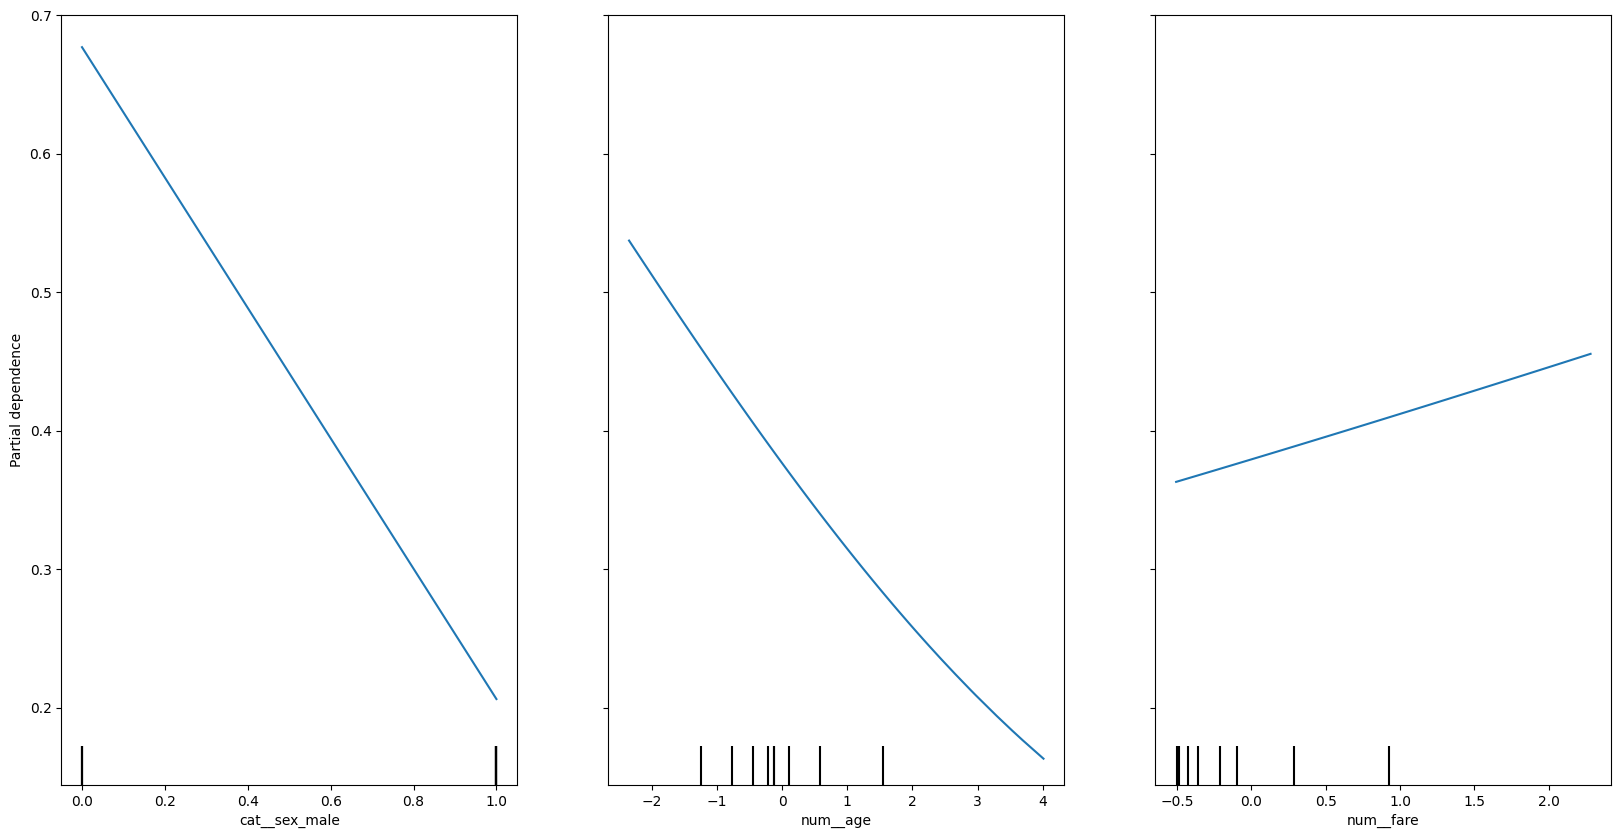

In [ ]:
PartialDependenceDisplay.from_estimator(clf, test_X, ['cat__sex_male', 'num__age', 'num__fare'])

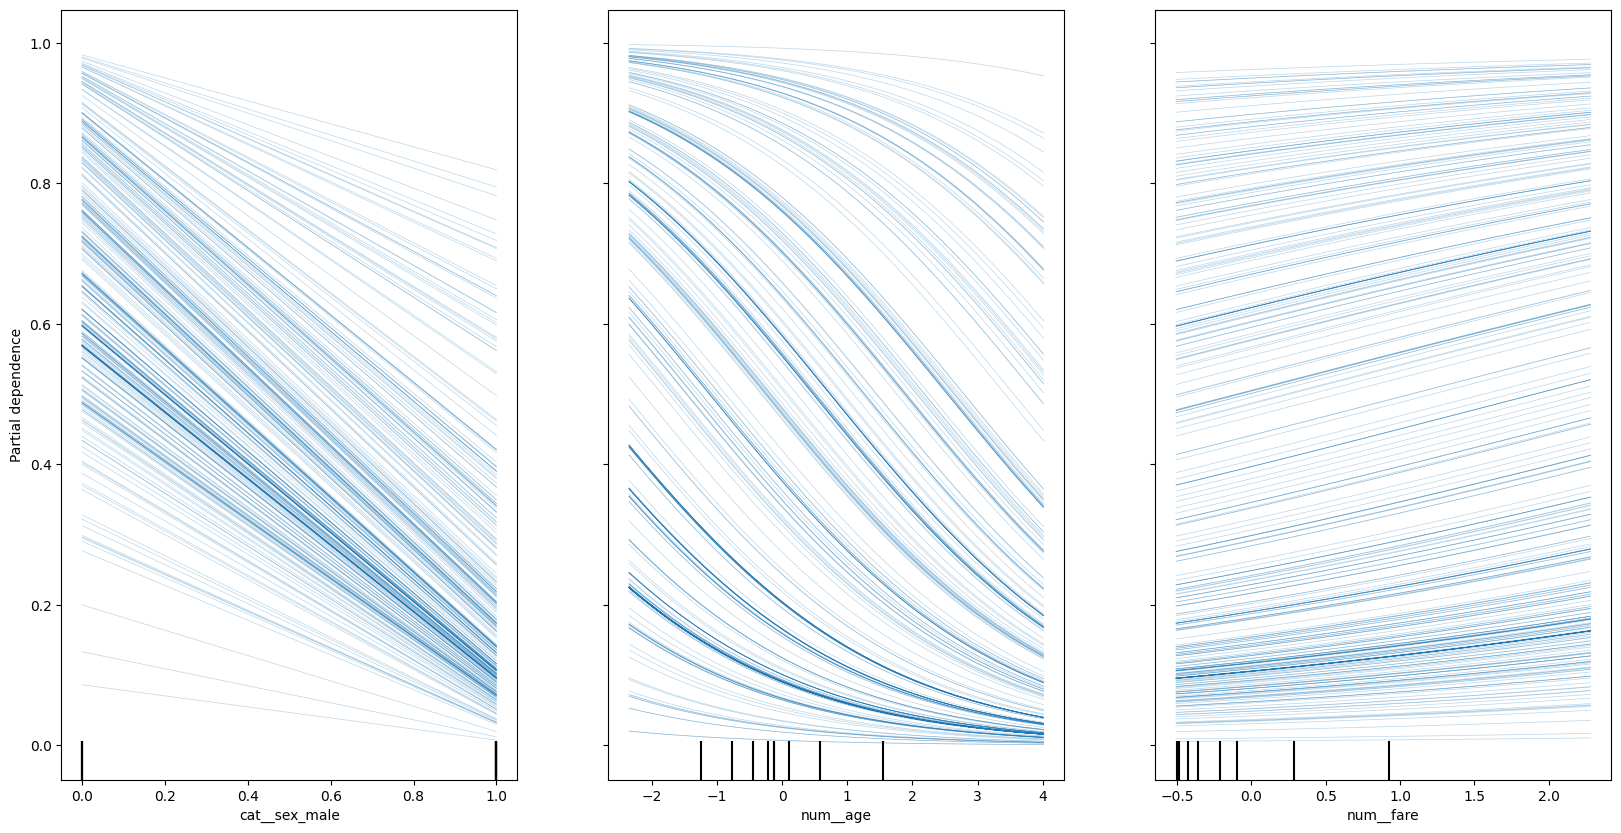

In [ ]:
PartialDependenceDisplay.from_estimator(clf,  test_X, ['cat__sex_male', 'num__age', 'num__fare'], kind='individual')

Shap scoring

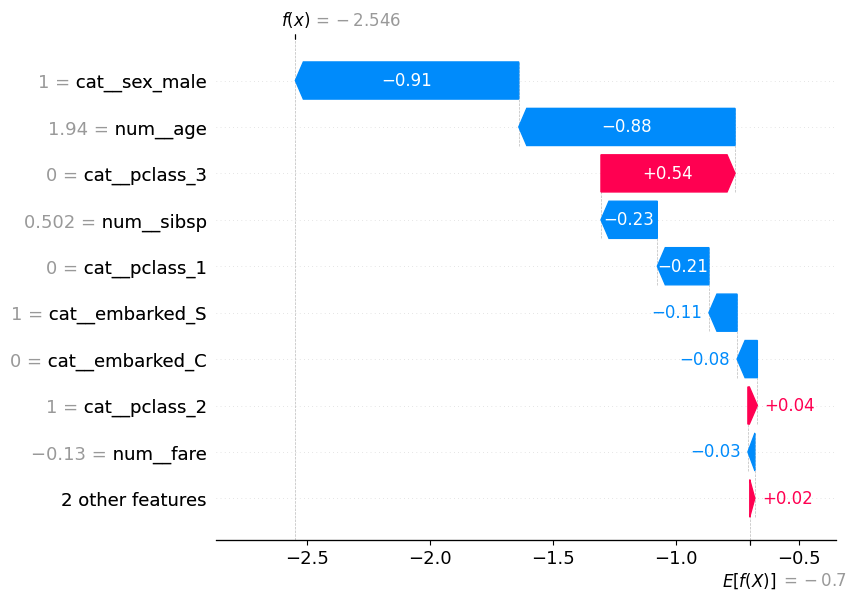

In [ ]:
explainer = shap.Explainer(clf, test_X)
shap_values = explainer(test_X)
shap.plots.waterfall(shap_values[0])

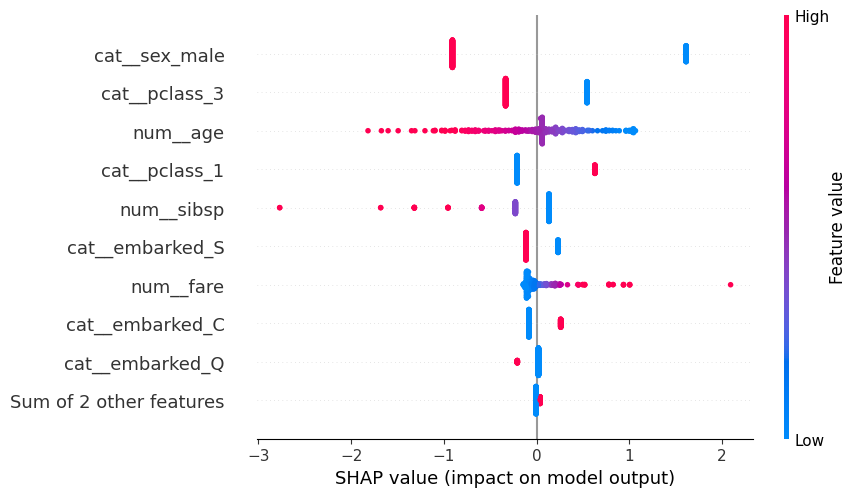

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
tlf = DecisionTreeClassifier(max_depth = 3).fit(train_X, train_y)

Plot the trees.

[Text(0.5, 0.875, 'cat__sex_male <= 0.5\ngini = 0.466\nsamples = 981\nvalue = [618, 363]'),
 Text(0.25, 0.625, 'cat__pclass_3 <= 0.5\ngini = 0.409\nsamples = 345\nvalue = [99, 246]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'num__fare <= -0.128\ngini = 0.103\nsamples = 183\nvalue = [10, 173]'),
 Text(0.0625, 0.125, 'gini = 0.225\nsamples = 62\nvalue = [8, 54]'),
 Text(0.1875, 0.125, 'gini = 0.033\nsamples = 121\nvalue = [2, 119]'),
 Text(0.375, 0.375, 'num__fare <= -0.154\ngini = 0.495\nsamples = 162\nvalue = [89, 73]'),
 Text(0.3125, 0.125, 'gini = 0.5\nsamples = 140\nvalue = [68, 72]'),
 Text(0.4375, 0.125, 'gini = 0.087\nsamples = 22\nvalue = [21, 1]'),
 Text(0.75, 0.625, 'num__age <= -2.083\ngini = 0.3\nsamples = 636\nvalue = [519.0, 117.0]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'num__sibsp <= 1.954\ngini = 0.355\nsamples = 13\nvalue = [3, 10]'),
 Text(0.5625, 0.125, 'gini = 0.18\nsamples = 10\nvalue = [1, 9]'),
 Text(0.6875, 0.125, 'gini = 0.444\nsamples =

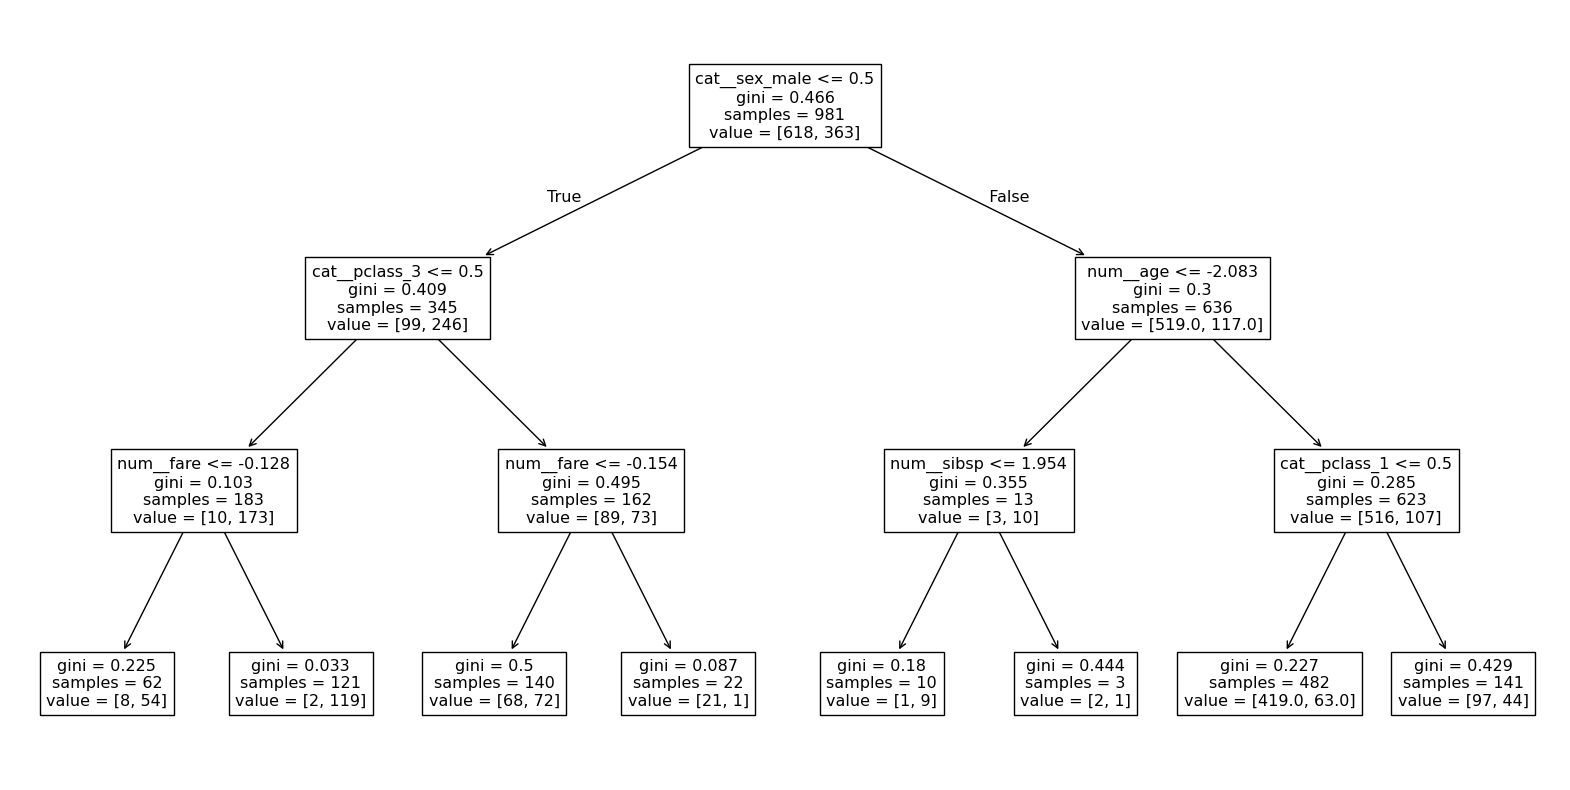

In [ ]:
plot_tree(tlf, feature_names = clf.feature_names_in_)

In [ ]:
test_pred['prob_tree'] =  tlf.predict_proba(test_X)[:,1]

In [ ]:
metric_runner(test_pred['truth'], test_pred['prob_tree'], 0.5)

{'f1': 0.751937984496124,
 'precision': 0.8016528925619835,
 'recall': 0.708029197080292,
 'roc_auc': 0.8411166736729467,
 'pr_auc': 0.7840355801190168}

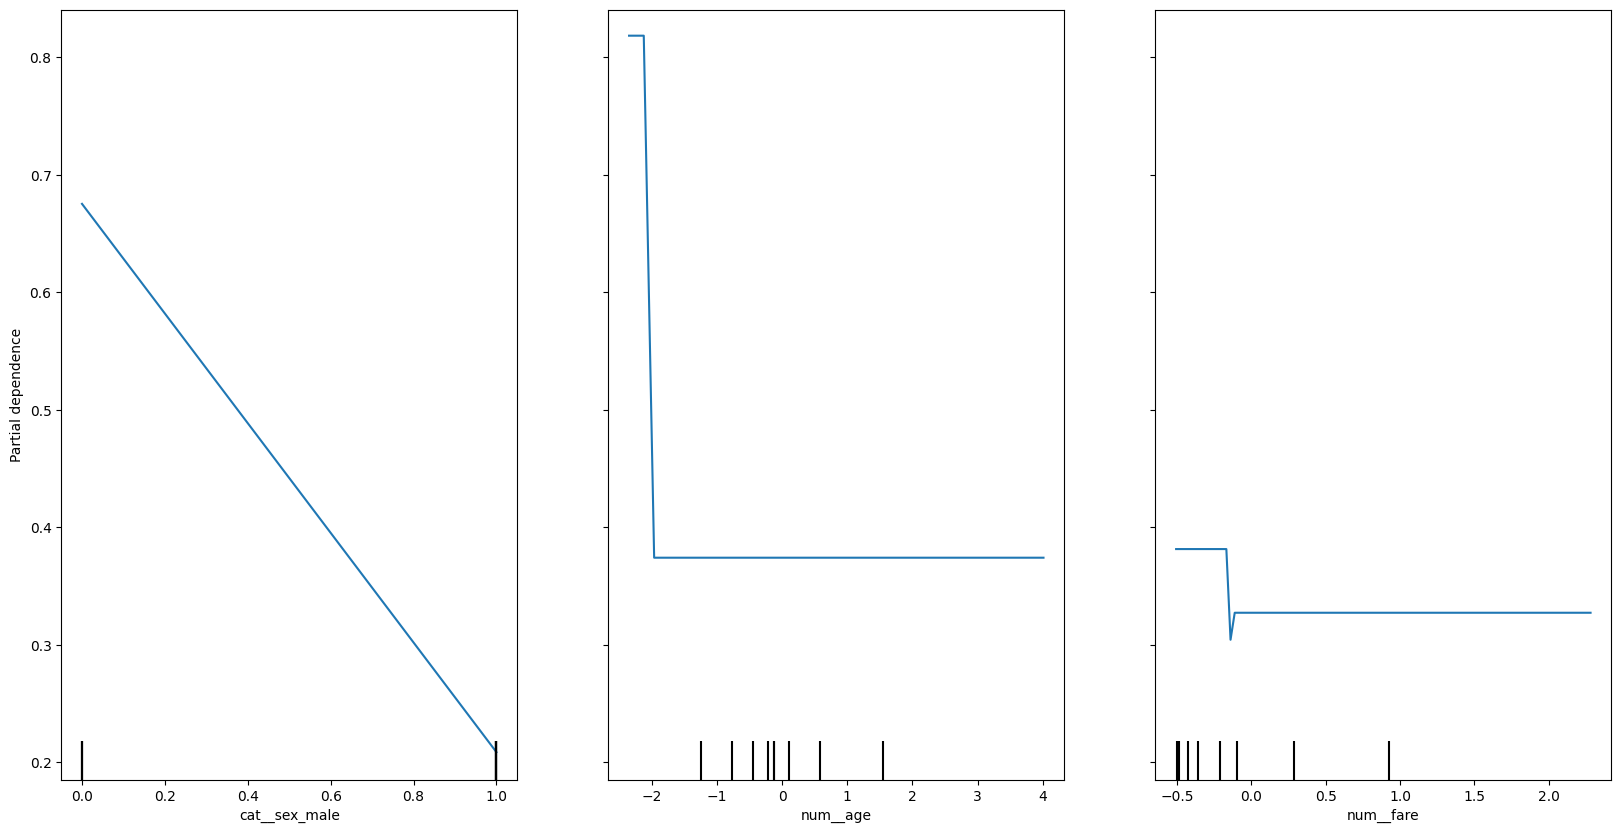

In [ ]:
PartialDependenceDisplay.from_estimator(tlf, test_X, ['cat__sex_male', 'num__age', 'num__fare'])

*screaming sounds*

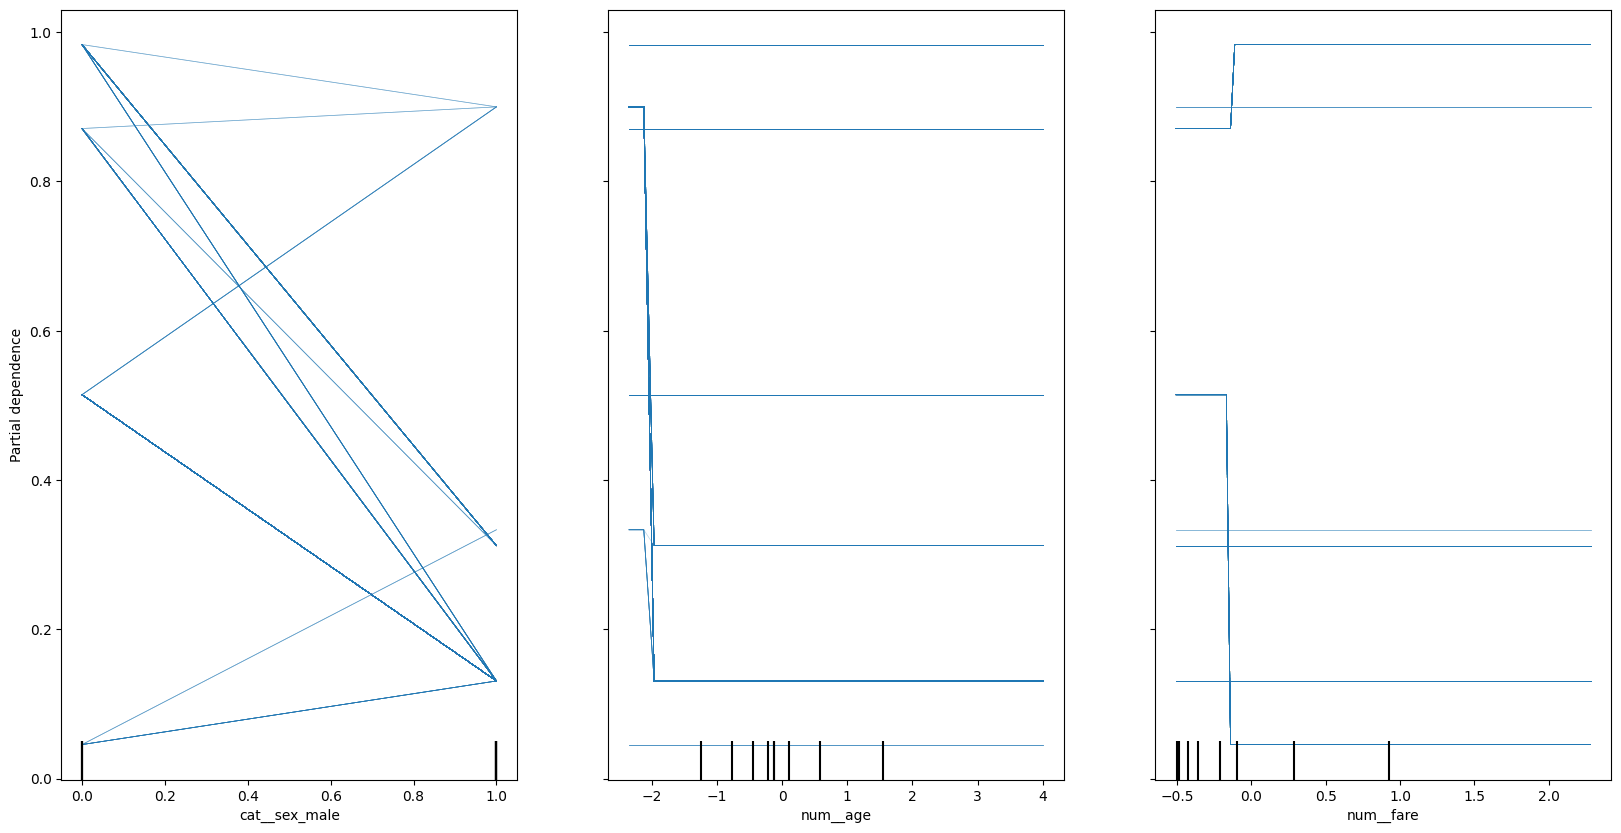

In [ ]:
PartialDependenceDisplay.from_estimator(tlf,  test_X, ['cat__sex_male', 'num__age', 'num__fare'], kind='individual')

In [ ]:
#we can also overfit like crazy

In [ ]:
tlf_overfit = DecisionTreeClassifier(max_depth = 150).fit(train_X, train_y)

[Text(0.41300076735817104, 0.9814814814814815, 'cat__sex_male <= 0.5\ngini = 0.466\nsamples = 981\nvalue = [618, 363]'),
 Text(0.16297099915325994, 0.9444444444444444, 'cat__pclass_3 <= 0.5\ngini = 0.409\nsamples = 345\nvalue = [99, 246]'),
 Text(0.2879858832557155, 0.962962962962963, 'True  '),
 Text(0.06265876375952582, 0.9074074074074074, 'num__fare <= -0.128\ngini = 0.103\nsamples = 183\nvalue = [10, 173]'),
 Text(0.04403048264182896, 0.8703703703703703, 'num__age <= 2.219\ngini = 0.225\nsamples = 62\nvalue = [8, 54]'),
 Text(0.03725656223539373, 0.8333333333333334, 'num__age <= -0.49\ngini = 0.203\nsamples = 61\nvalue = [7, 54]'),
 Text(0.03048264182895851, 0.7962962962962963, 'gini = 0.0\nsamples = 16\nvalue = [0, 16]'),
 Text(0.04403048264182896, 0.7962962962962963, 'num__age <= -0.171\ngini = 0.263\nsamples = 45\nvalue = [7, 38]'),
 Text(0.027095681625740897, 0.7592592592592593, 'num__age <= -0.331\ngini = 0.42\nsamples = 10\nvalue = [3, 7]'),
 Text(0.013547840812870448, 0.7222

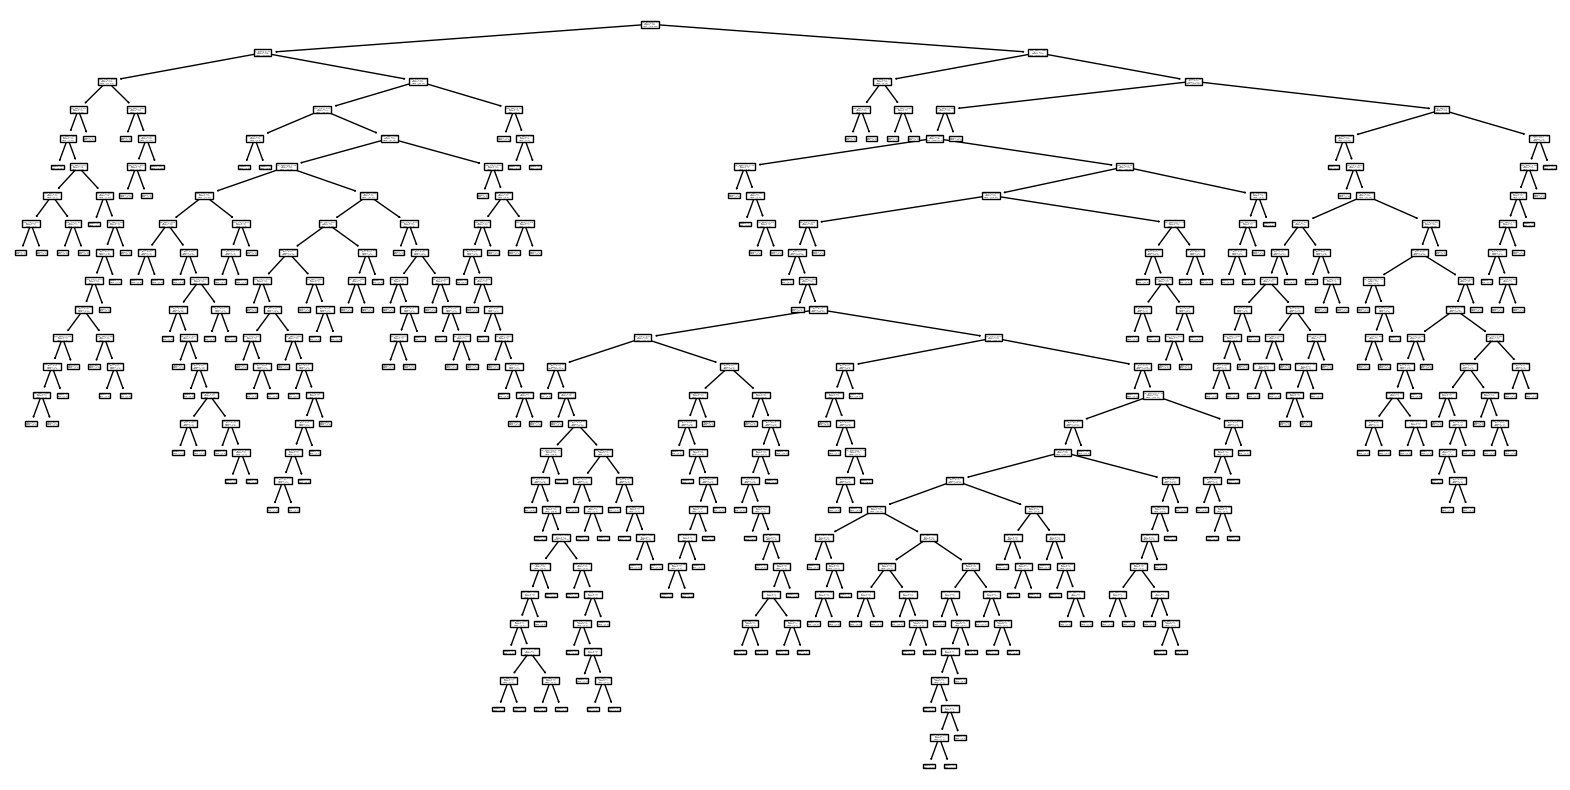

In [ ]:
plot_tree(tlf_overfit, feature_names = clf.feature_names_in_)

In [ ]:
test_pred['prob_tree_overfit'] =  tlf_overfit.predict_proba(test_X)[:,1]

In [ ]:
metric_runner(test_pred['truth'], test_pred['prob_tree_overfit'], 0.5)

{'f1': 0.7191011235955056,
 'precision': 0.7384615384615385,
 'recall': 0.7007299270072993,
 'roc_auc': 0.7638819887644743,
 'pr_auc': 0.6519228158142921}

In [ ]:
hlf = HistGradientBoostingClassifier().fit(train_X, train_y)

In [ ]:
test_pred['prob_hgb'] =  hlf.predict_proba(test_X)[:,1]

In [ ]:
metric_runner(test_pred['truth'], test_pred['prob_hgb'], 0.5)

{'f1': 0.732824427480916,
 'precision': 0.768,
 'recall': 0.7007299270072993,
 'roc_auc': 0.8689761913860969,
 'pr_auc': 0.8418053105426754}

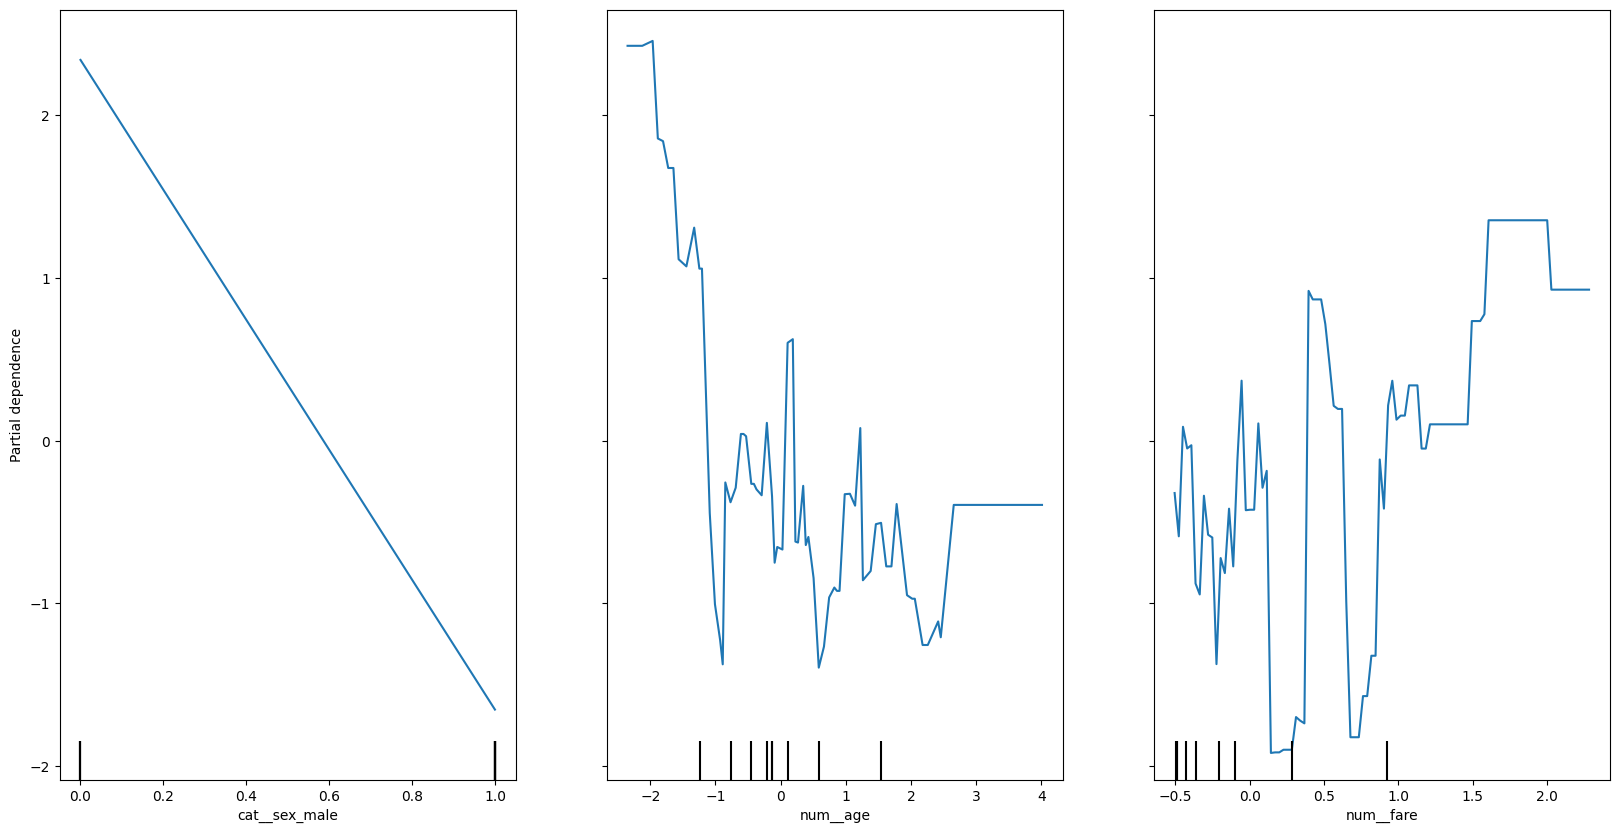

In [ ]:
PartialDependenceDisplay.from_estimator(hlf, test_X, ['cat__sex_male', 'num__age', 'num__fare'])

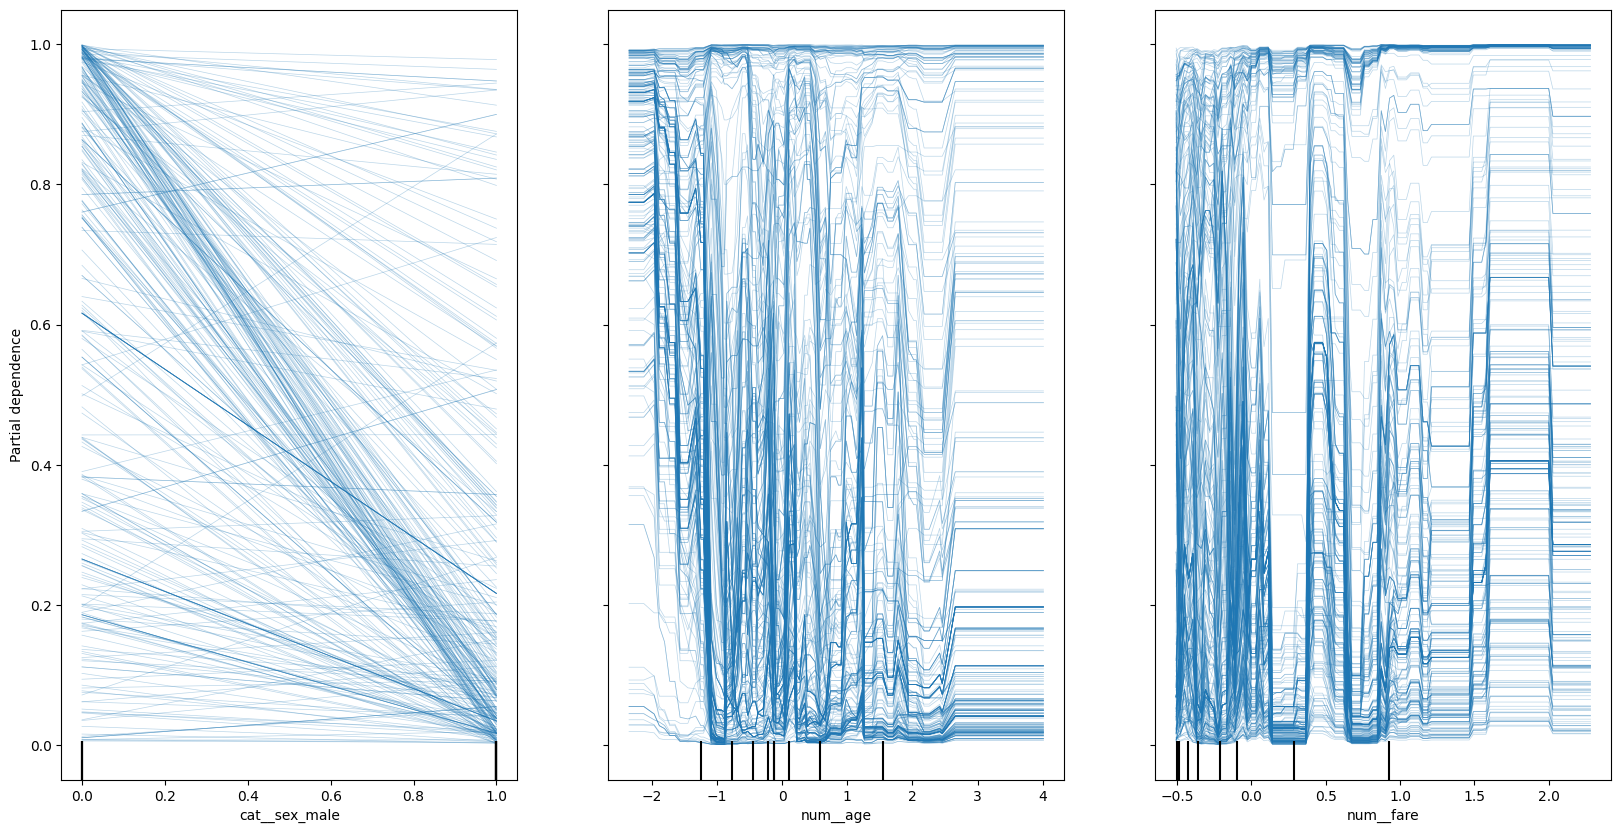

In [ ]:
PartialDependenceDisplay.from_estimator(hlf,  test_X, ['cat__sex_male', 'num__age', 'num__fare'], kind='individual')

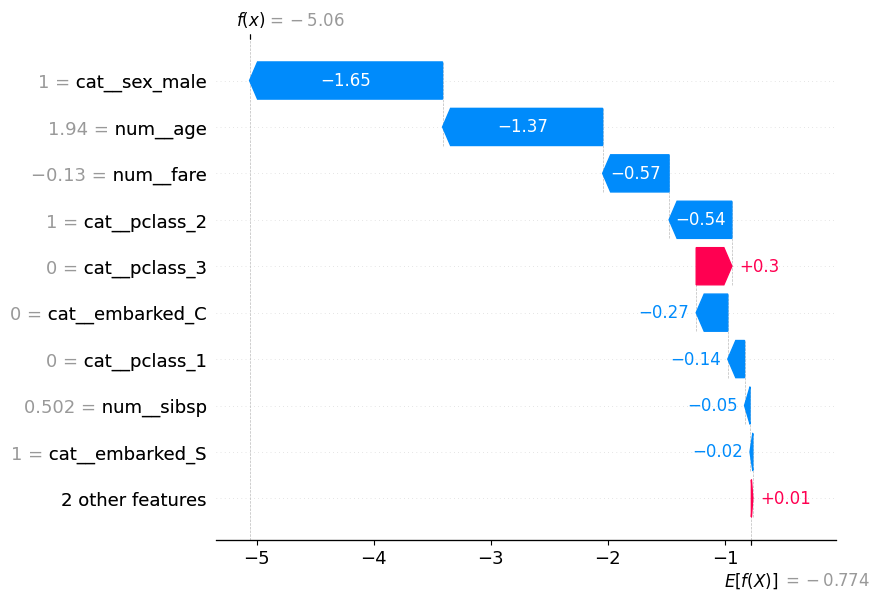

In [ ]:
explainer = shap.TreeExplainer(hlf)
shap_values = explainer(test_X)
shap.plots.waterfall(shap_values[0])

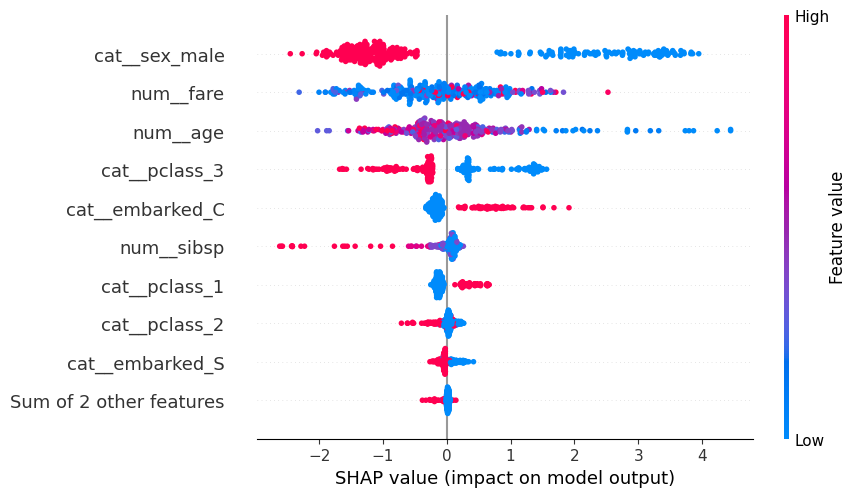

In [ ]:
shap.plots.beeswarm(shap_values)

We can permute the data.

In [ ]:
importance = permutation_importance(hlf, test_X, test_y)

In [ ]:
importance

{'importances_mean': array([ 0.03719512,  0.00670732,  0.01890244, -0.00243902,  0.        ,
         0.00182927,  0.        ,  0.15731707, -0.0152439 , -0.00304878,
         0.05304878]),
 'importances_std': array([0.01284836, 0.00731707, 0.01663193, 0.0059118 , 0.00272691,
        0.004563  , 0.        , 0.01182361, 0.00510159, 0.00333977,
        0.01488604]),
 'importances': array([[ 0.05487805,  0.03658537,  0.0152439 ,  0.04268293,  0.03658537],
        [ 0.00304878,  0.        ,  0.01219512,  0.        ,  0.01829268],
        [ 0.02439024,  0.00304878,  0.01219512,  0.00609756,  0.04878049],
        [ 0.00304878, -0.01219512,  0.        ,  0.00304878, -0.00609756],
        [-0.00304878,  0.        , -0.00304878,  0.00304878,  0.00304878],
        [ 0.00609756,  0.00609756,  0.00304878,  0.        , -0.00609756],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.1402439 ,  0.14634146,  0.16463415,  0.17073171,  0.16463415],
        [-0.0152439

In [ ]:
importances = pd.DataFrame(importance['importances_mean'], columns = ['avg_import'])
importances.index = hlf.feature_names_in_

In [ ]:
importances.sort_values('avg_import', ascending = False)

avg_import
cat__sex_male        0.157317
cat__pclass_3        0.053049
num__age             0.037195
num__fare            0.018902
num__sibsp           0.006707
cat__embarked_S      0.001829
cat__embarked_Q      0.000000
cat__embarked_nan    0.000000
cat__embarked_C     -0.002439
cat__pclass_2       -0.003049
cat__pclass_1       -0.015244

In [ ]:

# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [20, 50, 100]
}


In [ ]:
grid_search = GridSearchCV(hlf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model with the best parameters
grid_search.fit(train_X, train_y)

# Display the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

({'learning_rate': 0.2,
  'max_depth': 3,
  'max_iter': 300,
  'min_samples_leaf': 50},
 0.8124210090127422)

In [ ]:
best_params

{'learning_rate': 0.2, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 50}

In [ ]:
best_model = grid_search.best_estimator_

In [ ]:
test_pred['prob_hgb_tuned'] =  best_model.predict_proba(test_X)[:,1]

In [ ]:
metric_runner(test_pred['truth'], test_pred['prob_hgb_tuned'], 0.5)

{'f1': 0.7410358565737052,
 'precision': 0.8157894736842105,
 'recall': 0.6788321167883211,
 'roc_auc': 0.8830205984637138,
 'pr_auc': 0.852448901064419}

In [ ]:
param_space = {
    'learning_rate': (0.01, 0.2, 'log-uniform'),
    'max_iter': (100, 500),
    'max_depth': (3, 10),
    'min_samples_leaf': (10, 200),
    'max_leaf_nodes': (15, 31),
}

# Setup BayesSearchCV
bayes_search = BayesSearchCV(
    hlf,
    param_space,
    n_iter=32,  # Number of parameter settings sampled
    cv=5,       # 5-fold cross-validation
    scoring='accuracy',  # Scoring based on accuracy
    n_jobs=-1,  # Use all processors
    random_state=42
)

# Fit the model with the best parameters found by Bayesian Optimization
bayes_search.fit(train_X, train_y)

BayesSearchCV(cv=5, estimator=HistGradientBoostingClassifier(), n_iter=32,
              n_jobs=-1, random_state=42, scoring='accuracy',
              search_spaces={'learning_rate': (0.01, 0.2, 'log-uniform'),
                             'max_depth': (3, 10), 'max_iter': (100, 500),
                             'max_leaf_nodes': (15, 31),
                             'min_samples_leaf': (10, 200)})

In [ ]:
best_params_bayes = bayes_search.best_params_
best_score_bayes = bayes_search.best_score_
best_model_bayes = bayes_search.best_estimator_

In [ ]:
print(best_params_bayes)

OrderedDict([('learning_rate', 0.039807933399801355), ('max_depth', 3), ('max_iter', 218), ('max_leaf_nodes', 15), ('min_samples_leaf', 10)])


In [ ]:
test_pred['prob_hgb_tuned_bayes'] =  best_model_bayes.predict_proba(test_X)[:,1]

In [ ]:
metric_runner(test_pred['truth'], test_pred['prob_hgb_tuned_bayes'], 0.5)

{'f1': 0.726530612244898,
 'precision': 0.8240740740740741,
 'recall': 0.6496350364963503,
 'roc_auc': 0.8770779990063821,
 'pr_auc': 0.8523978342527108}

We can also use neural networks to fit various models

In [ ]:
train_dataset = TensorDataset(torch.tensor(train_X.values), torch.tensor(train_y.values.reshape(-1,1)))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=100)

In [ ]:
n_features = train_X.shape[1]

In [ ]:
class TitanicModel(nn.Module):
    def __init__(self):
        super(TitanicModel, self).__init__()
        self.layer_1 = nn.Linear(n_features, 64)
        self.layer_2 = nn.Linear(64, 32)
        self.layer_3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.sigmoid(self.layer_3(x))
        return x

In [ ]:
# Initialize the model, define loss and optimizer
model = TitanicModel()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_X_tensor = torch.FloatTensor(train_X.values)
train_y_tensor = torch.FloatTensor(train_y.values).view(-1, 1)

In [ ]:
num_epochs = 50

In [ ]:
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    predictions = model(train_X_tensor)
    loss = criterion(predictions, train_y_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Step 4: Evaluate the model
model.eval()

Epoch [10/50], Loss: 0.6560
Epoch [20/50], Loss: 0.6268
Epoch [30/50], Loss: 0.5977
Epoch [40/50], Loss: 0.5675
Epoch [50/50], Loss: 0.5352


TitanicModel(
  (layer_1): Linear(in_features=11, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [ ]:
X_test_tensor = torch.FloatTensor(test_X.values)
y_test_tensor = torch.FloatTensor(test_y.values).view(-1, 1)

with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_predictions = test_predictions.round()


In [ ]:
metric_runner(test_y, test_predictions.numpy(), 0.5)

{'f1': 0.4512820512820513,
 'precision': 0.7586206896551724,
 'recall': 0.32116788321167883,
 'roc_auc': 0.6239347269461536,
 'pr_auc': 0.5271811864229893}

Neural Networks can unpack a lot of different datasets.

In [ ]:
# Step 1: Load the Fashion-MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean 0.5 and std 0.5
])

In [ ]:
# Download and create training and test datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:

# Create data loaders
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:


# Step 2: Build a simple CNN model
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        # Convolutional layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, 10)  # Output layer for 10 classes (T-shirt, Trouser, etc.)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv layer 1 + ReLU + Pooling
        x = self.pool(self.relu(self.conv2(x)))  # Conv layer 2 + ReLU + Pooling
        x = x.view(-1, 64 * 7 * 7)  # Flatten the output from convolutional layers
        x = self.relu(self.fc1(x))  # Fully connected layer + ReLU
        x = self.fc2(x)  # Output layer
        return x


In [ ]:

# Step 3: Define the model, loss function, and optimizer
model = FashionCNN()

In [ ]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:

# Step 4: Train the model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/5], Loss: 0.4252
Epoch [2/5], Loss: 0.2726
Epoch [3/5], Loss: 0.2268
Epoch [4/5], Loss: 0.1934
Epoch [5/5], Loss: 0.1673


In [ ]:
# Step 5: Evaluate the model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # Disable gradient calculation for testing
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


In [ ]:
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

Accuracy of the model on the test images: 90.94%


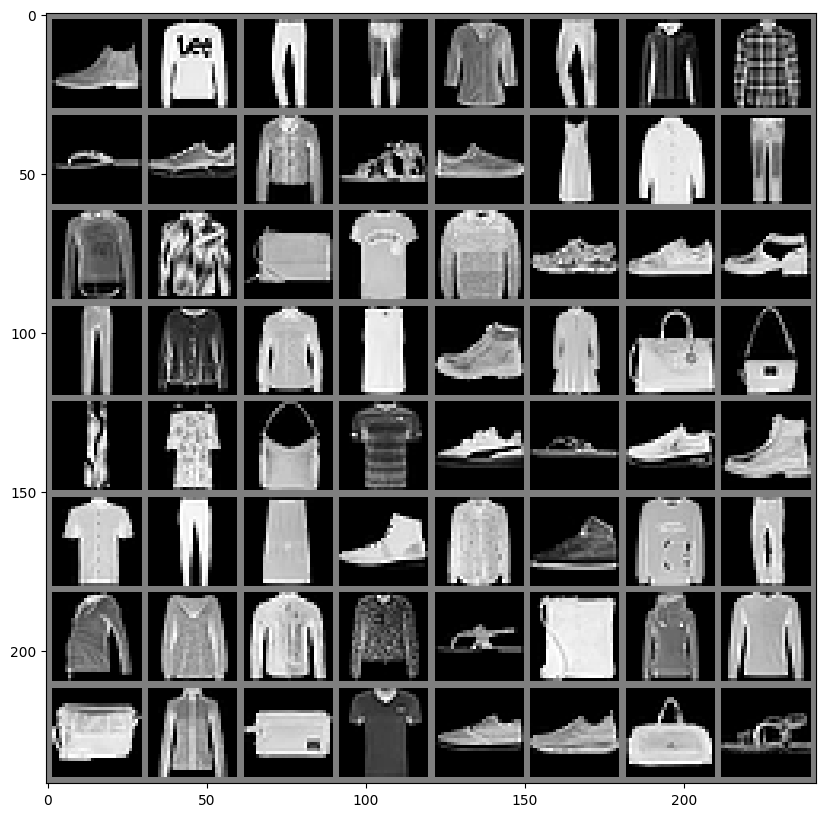

GroundTruth:  Ankle boot Pullover Trouser Trouser Shirt Trouser Coat Shirt
Predicted:  Ankle boot Pullover Trouser Trouser Shirt Trouser Coat Shirt


In [ ]:
# Step 6: Visualize some test results
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Use next() to get the next batch

# Print images
imshow(torchvision.utils.make_grid(images))

# Print the ground truth labels and the predicted labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(8)))

# Predict and print the predictions
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]}' for j in range(8)))
